# **Proyek Klasifikasi Gambar:  Animals-10 Classification**
- **Nama:** Muhammad Hasan Fadhlillah
- **Email:** mc006d5y2342@student.devacademy.id
- **ID Dicoding:** MC006D5Y2342

## Ringkasan Proyek
Proyek ini bertujuan untuk membangun model klasifikasi gambar menggunakan Convolutional Neural Network (CNN) untuk mengklasifikasikan 10 jenis hewan dari dataset "Animals-10". Dataset ini berisi sekitar 28.000 gambar. Model akan dilatih untuk mencapai akurasi tinggi (>95%) dan kemudian dikonversi ke format SavedModel, TF-Lite, dan TFJS. Proyek ini juga mengimplementasikan berbagai praktik terbaik seperti penggunaan callback, data augmentation, dan inferensi model.

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install split-folders -q
!pip install tensorflowjs -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
pandas-gbq 0.28.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


In [2]:
# ========== BAGIAN 1: SETUP DAN IMPORT ==========

import os
import shutil
import zipfile
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0  # Transfer Learning
from PIL import Image
import splitfolders
import random

# Mengabaikan peringatan yang tidak perlu
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")

2025-06-10 10:40:36.607866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749552037.039579      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749552037.162330      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0


## Data Preparation

### Data Preparation & Path Setup for Kaggle

In [3]:
# ========== BAGIAN 2: PATH SETUP ==========
dataset_input_name_kaggle = 'animals10'
base_dataset_dir = f'/kaggle/input/{dataset_input_name_kaggle}/raw-img'

# Path untuk direktori kerja di Kaggle
working_dir = '/kaggle/working/'

# Path untuk data yang sudah diproses
output_folder = os.path.join(working_dir, 'processed_data')
reduced_folder = os.path.join(working_dir, 'reduced_data')  # Folder untuk data yang dikurangi
train_dir = os.path.join(output_folder, 'train')
validation_dir = os.path.join(output_folder, 'val')
test_dir = os.path.join(output_folder, 'test')

# Path untuk model checkpoints
checkpoint_dir = os.path.join(working_dir, 'model_checkpoints/')

# Path untuk submission
submission_dir = os.path.join(working_dir, 'submission')
saved_model_dir = os.path.join(submission_dir, 'saved_model')
tflite_model_dir = os.path.join(submission_dir, 'tflite_model')
tfjs_model_dir = os.path.join(submission_dir, 'tfjs_model')

# Membuat direktori yang diperlukan
for dir_path in [output_folder, checkpoint_dir, submission_dir, saved_model_dir, tflite_model_dir, tfjs_model_dir]:
    if not os.path.exists(dir_path): 
        os.makedirs(dir_path)

print(f"Base dataset directory: {base_dataset_dir}")
print(f"Processed data output directory: {output_folder}")

Base dataset directory: /kaggle/input/animals10/raw-img
Processed data output directory: /kaggle/working/processed_data


### Data Loading

In [4]:
if os.path.exists(base_dataset_dir):
    print(f"Base dataset directory: {base_dataset_dir} ditemukan.")
    try:
        print("Classes found:", os.listdir(base_dataset_dir))
    except FileNotFoundError:
        print(f"ERROR: Isi dari {base_dataset_dir} tidak dapat diakses. Pastikan path 'raw-img' benar di dalam folder dataset Anda.")
else:
    print(f"ERROR: Directory {base_dataset_dir} TIDAK ditemukan. Pastikan path dataset benar dan dataset sudah ditambahkan ke notebook Kaggle.")
    print("Silakan periksa panel 'Data' di Kaggle dan sesuaikan 'dataset_input_name_kaggle'.")
    print("Pastikan juga subfolder 'raw-img' ada di dalam path tersebut.")

Base dataset directory: /kaggle/input/animals10/raw-img ditemukan.
Classes found: ['cavallo', 'pecora', 'elefante', 'gatto', 'scoiattolo', 'gallina', 'ragno', 'mucca', 'cane', 'farfalla']


### Data Reduction

In [5]:
# ========== BAGIAN 3: DATA REDUCTION ==========
def reduce_dataset(source_dir, target_dir, max_images_per_class=1300):
    """
    Mengurangi dataset dengan mengambil maksimal max_images_per_class gambar per kelas
    """
    if os.path.exists(target_dir):
        shutil.rmtree(target_dir)
    os.makedirs(target_dir)
    
    total_original = 0
    total_reduced = 0
    
    for class_name in os.listdir(source_dir):
        class_source_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_source_path):
            continue
            
        class_target_path = os.path.join(target_dir, class_name)
        os.makedirs(class_target_path, exist_ok=True)
        
        # Ambil semua file gambar
        image_files = [f for f in os.listdir(class_source_path) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        total_original += len(image_files)
        
        # Shuffle dan ambil maksimal max_images_per_class
        random.shuffle(image_files)
        selected_files = image_files[:max_images_per_class]
        
        # Copy file yang dipilih
        for file_name in selected_files:
            source_file = os.path.join(class_source_path, file_name)
            target_file = os.path.join(class_target_path, file_name)
            shutil.copy2(source_file, target_file)
        
        total_reduced += len(selected_files)
        print(f"Class {class_name}: {len(image_files)} -> {len(selected_files)} images")
    
    print(f"\nTotal images: {total_original} -> {total_reduced}")
    return target_dir

# Gunakan dataset yang dikurangi jika diinginkan
USE_REDUCED_DATASET = True  # Ubah ke False jika ingin menggunakan dataset penuh

if USE_REDUCED_DATASET:
    if os.path.exists(base_dataset_dir):
        print("Reducing dataset size...")
        dataset_to_use = reduce_dataset(base_dataset_dir, reduced_folder, max_images_per_class=1300)
    else:
        print(f"Base dataset directory not found: {base_dataset_dir}")
        dataset_to_use = base_dataset_dir
else:
    dataset_to_use = base_dataset_dir

Reducing dataset size...
Class cavallo: 2623 -> 1300 images
Class pecora: 1820 -> 1300 images
Class elefante: 1446 -> 1300 images
Class gatto: 1668 -> 1300 images
Class scoiattolo: 1862 -> 1300 images
Class gallina: 3098 -> 1300 images
Class ragno: 4821 -> 1300 images
Class mucca: 1866 -> 1300 images
Class cane: 4863 -> 1300 images
Class farfalla: 2112 -> 1300 images

Total images: 26179 -> 13000


### Eksplorasi Data Awal
Mengecek jumlah gambar per kelas dan resolusi gambar (untuk memenuhi saran "Resolusi Gambar Asli Tidak Seragam").

In [6]:
def print_images_resolution_and_count(directory):
    unique_sizes = {} # Menyimpan ukuran unik dan jumlahnya
    total_images = 0
    class_counts = {}

    print("Image counts and resolutions per class:")
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            image_files = [f for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))]
            num_images = len(image_files)
            class_counts[subdir] = num_images
            print(f"Class: {subdir}, Image Count: {num_images}")
            total_images += num_images

            class_unique_sizes = set()
            for img_file in image_files:
                img_path = os.path.join(subdir_path, img_file)
                try:
                    with Image.open(img_path) as img:
                        size = img.size
                        class_unique_sizes.add(size)
                        unique_sizes[size] = unique_sizes.get(size, 0) + 1
                except Exception as e:
                    print(f"Could not open or read image {img_path}: {e}")

            print(f"  Unique resolutions in {subdir} (first 5): {list(class_unique_sizes)[:5]}")
            if len(class_unique_sizes) > 5:
                print(f"  ... and {len(class_unique_sizes) - 5} more unique resolutions.")
            print("---------------")

    print(f"\nTotal images in dataset: {total_images}")
    print(f"Total unique resolutions found across all images: {len(unique_sizes)}")

    # Menampilkan beberapa contoh resolusi unik dan frekuensinya
    print("\nTop 5 most common resolutions:")
    sorted_resolutions = sorted(unique_sizes.items(), key=lambda item: item[1], reverse=True)
    for size, count in sorted_resolutions[:5]:
        print(f"- Resolution {size}: {count} images")

    if len(sorted_resolutions) > 5:
         print(f"  ... and {len(sorted_resolutions) - 5} more unique resolutions.")

    return class_counts, unique_sizes


if os.path.exists(base_dataset_dir) and os.listdir(base_dataset_dir): # Pastikan direktori ada dan tidak kosong
    class_counts, unique_resolutions = print_images_resolution_and_count(base_dataset_dir)
else:
    print(f"Cannot perform exploration, directory {base_dataset_dir} not found or is empty.")

Image counts and resolutions per class:
Class: cavallo, Image Count: 2623
  Unique resolutions in cavallo (first 5): [(300, 270), (300, 279), (300, 126), (300, 135), (249, 300)]
  ... and 307 more unique resolutions.
---------------
Class: pecora, Image Count: 1820
  Unique resolutions in pecora (first 5): [(300, 108), (300, 135), (300, 144), (296, 250), (160, 240)]
  ... and 331 more unique resolutions.
---------------
Class: elefante, Image Count: 1446
  Unique resolutions in elefante (first 5): [(300, 206), (640, 320), (300, 270), (232, 300), (640, 384)]
  ... and 279 more unique resolutions.
---------------
Class: gatto, Image Count: 1668
  Unique resolutions in gatto (first 5): [(449, 640), (300, 270), (300, 126), (238, 300), (249, 300)]
  ... and 399 more unique resolutions.
---------------
Class: scoiattolo, Image Count: 1862
  Unique resolutions in scoiattolo (first 5): [(300, 206), (245, 300), (232, 300), (240, 194), (300, 215)]
  ... and 274 more unique resolutions.
---------

### Data Preprocessing

#### Split Dataset

Kita akan membagi dataset menjadi train (70%), validation (15%), dan test (15%). Menggunakan library `split-folders` untuk memudahkan pembagian.

In [7]:
# ========== BAGIAN 4: DATA SPLITTING ==========
# Hapus direktori output jika sudah ada
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)
os.makedirs(output_folder, exist_ok=True)

if os.path.exists(dataset_to_use) and os.listdir(dataset_to_use):
    print(f"Splitting dataset from: {dataset_to_use}")
    # Split dengan rasio train:val:test = 70:15:15
    splitfolders.ratio(dataset_to_use, output=output_folder, seed=42, ratio=(.7, .15, .15))
    print("Dataset split successfully.")
else:
    print(f"Dataset directory not found or empty: {dataset_to_use}")

Splitting dataset from: /kaggle/working/reduced_data


Copying files: 13000 files [00:02, 6081.49 files/s]

Dataset split successfully.


#### Image Data Generator

Menggunakan `ImageDataGenerator` untuk augmentasi data training dan normalisasi gambar.

In [8]:
# ========== BAGIAN 5: DATA GENERATORS ==========
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 16  # Reduced batch size for better convergence

# Augmentasi yang lebih agresif untuk training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=False,  # Tidak cocok untuk hewan
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.2,
    fill_mode='nearest'
)

# Hanya rescaling untuk validation dan test
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Membuat generators
if all(os.path.exists(d) for d in [train_dir, validation_dir, test_dir]):
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    class_names = list(train_generator.class_indices.keys())
    num_classes = len(class_names)
    print(f"Class names: {class_names}")
    print(f"Number of classes: {num_classes}")
    
    # Save labels
    labels_txt_path = os.path.join(tflite_model_dir, 'labels.txt')
    with open(labels_txt_path, 'w') as f:
        for item in class_names:
            f.write(f"{item}\n")
    print(f"labels.txt created at {labels_txt_path}")

Found 9090 images belonging to 10 classes.
Found 1950 images belonging to 10 classes.
Found 1960 images belonging to 10 classes.
Class names: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Number of classes: 10
labels.txt created at /kaggle/working/submission/tflite_model/labels.txt


## Modelling
Membangun model CNN menggunakan Keras Sequential API. Arsitektur akan mencakup Conv2D, MaxPooling2D, Dropout, dan BatchNormalization untuk mencapai akurasi >95%.

In [9]:
# ========== BAGIAN 6: MODEL ARCHITECTURE ==========
tf.keras.backend.clear_session()

# Menggunakan Transfer Learning dengan EfficientNetB0
def create_improved_model(num_classes, img_height=224, img_width=224):
    # Load pre-trained EfficientNetB0
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(img_height, img_width, 3)
    )
    
    # Freeze base model initially
    base_model.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    
    return model, base_model

# Alternative: Custom CNN yang lebih dalam
def create_custom_cnn(num_classes, img_height=224, img_width=224):
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        # Block 2
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        # Block 3
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        # Block 4
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        # Block 5
        Conv2D(512, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(512, (3, 3), activation='relu'),
        GlobalAveragePooling2D(),  # Better than Flatten
        
        # Dense layers
        BatchNormalization(),
        Dropout(0.5),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Pilih arsitektur model
USE_TRANSFER_LEARNING = True  # False jika menggunakan custom CNN

if USE_TRANSFER_LEARNING:
    model, base_model = create_improved_model(num_classes)
    print("Using Transfer Learning with EfficientNetB0")
else:
    model = create_custom_cnn(num_classes)
    print("Using Custom CNN")

# Compile model with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Learning rate lebih kecil
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

I0000 00:00:1749552386.802145      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749552386.803045      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Using Transfer Learning with EfficientNetB0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,847,533 (18.49 MB)

 Trainable params: 793,866 (3.03 MB)

 Non-trainable params: 4,053,667 (15.46 MB)

### Callbacks
Mengimplementasikan `ModelCheckpoint`, `EarlyStopping`, dan `ReduceLROnPlateau`.

In [10]:
# ========== BAGIAN 7: CALLBACKS ==========
# ModelCheckpoint
model_checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best_model.keras'),
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_weights_only=False  # Save full model
)

# EarlyStopping dengan patience yang lebih besar
early_stopping_cb = EarlyStopping(
    monitor='val_accuracy',
    patience=15,  # Increased patience
    verbose=1,
    restore_best_weights=True,
    min_delta=0.001  # Minimum change to qualify as improvement
)

# ReduceLROnPlateau
reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce learning rate by half
    patience=5,
    verbose=1,
    min_lr=1e-7,
    min_delta=0.001
)

callbacks_list = [model_checkpoint_cb, early_stopping_cb, reduce_lr_cb]

### Model Training

In [11]:
# ========== BAGIAN 8: TRAINING PHASE 1 (FROZEN BASE) ==========
if USE_TRANSFER_LEARNING:
    print("Phase 1: Training with frozen base model")
    
    # Re-compile dengan learning rate lebih tinggi untuk fase ini
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks khusus untuk Fase 1 (tanpa ReduceLROnPlateau)
    early_stopping_phase1_cb = EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        verbose=1,
        restore_best_weights=True,
        min_delta=0.001
    )
    
    history_phase1 = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        callbacks=[model_checkpoint_cb, early_stopping_phase1_cb],
        verbose=1
    )
    
    # ========== BAGIAN 9: TRAINING PHASE 2 (FINE-TUNING) ==========
    print("Phase 2: Fine-tuning - unfreezing base model")
    
    # Unfreeze base model
    base_model.trainable = True
    
    # Use very low learning rate for fine-tuning
    model.compile(
        optimizer=Adam(learning_rate=1e-5), # 0.00001
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Reset callbacks paths for phase 2
    model_checkpoint_cb_phase2 = ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, 'best_model_finetuned.keras'),
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    )
    
    callbacks_list_phase2 = [model_checkpoint_cb_phase2, early_stopping_cb, reduce_lr_cb]
    
    history_phase2 = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=100,  # More epochs for fine-tuning
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        callbacks=callbacks_list_phase2,
        verbose=1
    )
    
    # Use the best fine-tuned model
    best_model_path = os.path.join(checkpoint_dir, 'best_model_finetuned.keras')
else:
    # Single phase training for custom CNN
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=100,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        callbacks=callbacks_list,
        verbose=1
    )
    best_model_path = os.path.join(checkpoint_dir, 'best_model.keras')

Phase 1: Training with frozen base model
Epoch 1/20


I0000 00:00:1749552410.754274     130 service.cc:148] XLA service 0x79c220116410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749552410.755844     130 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749552410.755873     130 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749552413.404287     130 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/568 ━━━━━━━━━━━━━━━━━━━━ 5:42:28 36s/step - accuracy: 0.2500 - loss: 3.3085

I0000 00:00:1749552427.241209     130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


568/568 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.1037 - loss: 2.8193
Epoch 1: val_accuracy improved from -inf to 0.10021, saving model to /kaggle/working/model_checkpoints/best_model.keras
568/568 ━━━━━━━━━━━━━━━━━━━━ 199s 287ms/step - accuracy: 0.1037 - loss: 2.8190 - val_accuracy: 0.1002 - val_loss: 2.3346
Epoch 2/20
  1/568 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.2500 - loss: 2.3866
Epoch 2: val_accuracy did not improve from 0.10021
568/568 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2500 - loss: 2.3866 - val_accuracy: 0.1002 - val_loss: 2.3359
Epoch 3/20
568/568 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.1028 - loss: 2.4851
Epoch 3: val_accuracy improved from 0.10021 to 0.10072, saving model to /kaggle/working/model_checkpoints/best_model.keras
568/568 ━━━━━━━━━━━━━━━━━━━━ 142s 251ms/step - accuracy: 0.1028 - loss: 2.4851 - val_accuracy: 0.1007 - val_loss: 2.3437
Epoch 4/20
  1/568 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.0625 - loss: 2.5622
Epoch 

E0000 00:00:1749553984.352730     129 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749553984.493262     129 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749553984.844826     129 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749553984.989676     129 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


568/568 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.1414 - loss: 2.2840
Epoch 1: val_accuracy improved from -inf to 0.27169, saving model to /kaggle/working/model_checkpoints/best_model_finetuned.keras
568/568 ━━━━━━━━━━━━━━━━━━━━ 295s 341ms/step - accuracy: 0.1415 - loss: 2.2839 - val_accuracy: 0.2717 - val_loss: 2.0509 - learning_rate: 1.0000e-05
Epoch 2/100
  1/568 ━━━━━━━━━━━━━━━━━━━━ 37s 67ms/step - accuracy: 0.2500 - loss: 2.2091
Epoch 2: val_accuracy did not improve from 0.27169
568/568 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2500 - loss: 2.2091 - val_accuracy: 0.2696 - val_loss: 2.0508 - learning_rate: 1.0000e-05
Epoch 3/100
568/568 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.2573 - loss: 2.0445
Epoch 3: val_accuracy improved from 0.27169 to 0.27944, saving model to /kaggle/working/model_checkpoints/best_model_finetuned.keras
568/568 ━━━━━━━━━━━━━━━━━━━━ 152s 268ms/step - accuracy: 0.2573 - loss: 2.0444 - val_accuracy: 0.2794 - val_loss: 2.0174 - learning_rate:

## Evaluasi dan Visualisasi

In [12]:
# ========== BAGIAN 10: EVALUATION ==========
if os.path.exists(best_model_path):
    print(f"Loading best model from: {best_model_path}")
    model = tf.keras.models.load_model(best_model_path)
    
    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(
        test_generator,
        steps=test_generator.samples // BATCH_SIZE,
        verbose=1
    )
    
    print(f"\nFinal Test Results:")
    print(f"Test Accuracy: {test_accuracy*100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")
    
    if test_accuracy >= 0.95:
        print("🎉 EXCELLENT! Test accuracy >= 95% achieved!")
    elif test_accuracy >= 0.90:
        print("✅ GOOD! Test accuracy >= 90%")
    elif test_accuracy >= 0.85:
        print("⚠️  Test accuracy >= 85% but below 90%")
    else:
        print("❌ Test accuracy below 85%")

Loading best model from: /kaggle/working/model_checkpoints/best_model_finetuned.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9469 - loss: 0.1989

Final Test Results:
Test Accuracy: 95.18%
Test Loss: 0.1843
🎉 EXCELLENT! Test accuracy >= 95% achieved!


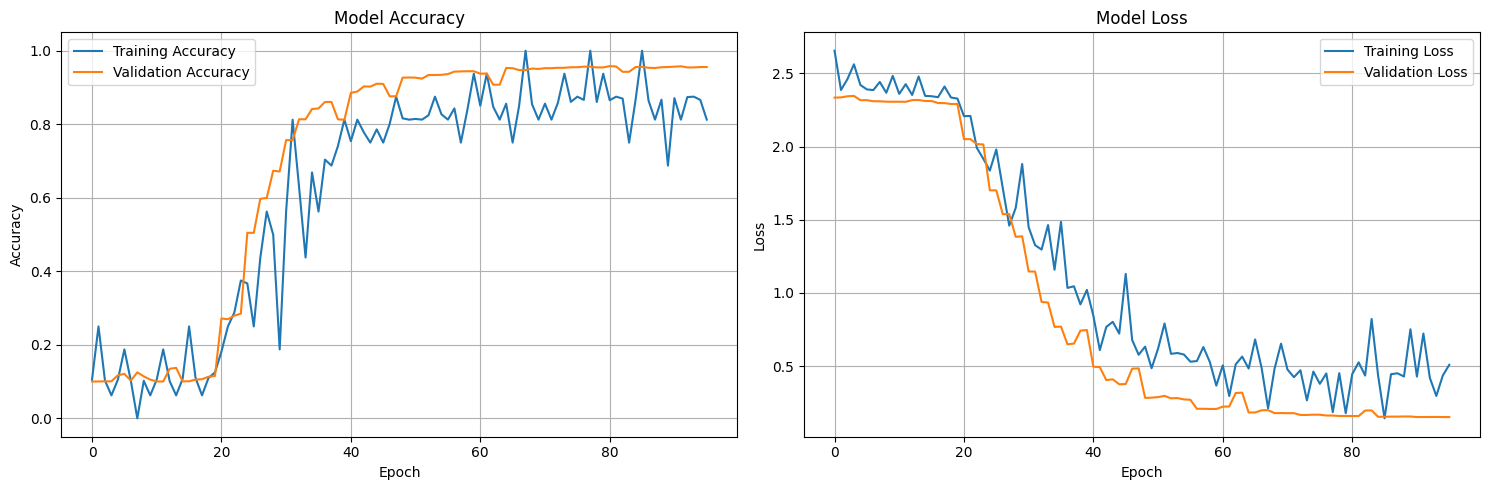


TRAINING COMPLETED!


In [13]:
# ========== BAGIAN 11: PLOTTING RESULTS ==========
def plot_training_history(histories, phase_names):
    """Plot training history for multiple phases"""
    plt.figure(figsize=(15, 5))
    
    # Combine histories
    combined_acc = []
    combined_val_acc = []
    combined_loss = []
    combined_val_loss = []
    
    for hist in histories:
        if hist and hist.history:
            combined_acc.extend(hist.history['accuracy'])
            combined_val_acc.extend(hist.history['val_accuracy'])
            combined_loss.extend(hist.history['loss'])
            combined_val_loss.extend(hist.history['val_loss'])
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(combined_acc, label='Training Accuracy')
    plt.plot(combined_val_acc, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(combined_loss, label='Training Loss')
    plt.plot(combined_val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot results
if USE_TRANSFER_LEARNING:
    if 'history_phase1' in locals() and 'history_phase2' in locals():
        plot_training_history([history_phase1, history_phase2], ['Phase 1', 'Phase 2'])
else:
    if 'history' in locals():
        plot_training_history([history], ['Training'])

print("\n" + "="*50)
print("TRAINING COMPLETED!")
print("="*50)

## Konversi Model
Menyimpan model ke dalam format SavedModel, TF-Lite, dan TFJS.

In [14]:
# ========== BAGIAN 12: MODEL CONVERSION ==========
print("Starting model conversion...")

# Load the best model for conversion
if os.path.exists(best_model_path):
    print(f"Loading model from: {best_model_path}")
    final_model = tf.keras.models.load_model(best_model_path)
    
    # 1. Save as SavedModel format
    print("Converting to SavedModel format...")
    try:
        final_model.export(saved_model_dir)
        print(f"✅ SavedModel saved to: {saved_model_dir}")
    except Exception as e:
        print(f"❌ Error saving SavedModel: {e}")
    
    # 2. Convert to TF-Lite
    print("Converting to TF-Lite format...")
    try:
        converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        
        # Optional: Add representative dataset for better quantization
        def representative_dataset():
            for _ in range(100):
                # Get a batch from validation generator
                batch = next(iter(validation_generator))
                yield [batch[0].astype(np.float32)]
        
        converter.representative_dataset = representative_dataset
        converter.target_spec.supported_ops = [
            tf.lite.OpsSet.TFLITE_BUILTINS,
            tf.lite.OpsSet.SELECT_TF_OPS  # Enable TF ops if needed
        ]
        
        tflite_model = converter.convert()
        
        tflite_model_path = os.path.join(tflite_model_dir, 'model.tflite')
        with open(tflite_model_path, 'wb') as f:
            f.write(tflite_model)
        print(f"✅ TF-Lite model saved to: {tflite_model_path}")
        
        # Check model size
        model_size = os.path.getsize(tflite_model_path) / (1024 * 1024)  # MB
        print(f"📊 TF-Lite model size: {model_size:.2f} MB")
        
    except Exception as e:
        print(f"❌ Error converting to TF-Lite: {e}")
    
    # 3. Convert to TensorFlow.js
    print("Converting to TensorFlow.js format...")
    try:
        os.system(f"tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model {saved_model_dir} {tfjs_model_dir}")
        print(f"✅ TFJS model saved to: {tfjs_model_dir}")
    except Exception as e:
        print(f"❌ Error converting to TFJS: {e}")

else:
    print(f"❌ Best model not found at: {best_model_path}")

Starting model conversion...
Loading model from: /kaggle/working/model_checkpoints/best_model_finetuned.keras
Converting to SavedModel format...
Saved artifact at '/kaggle/working/submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  133872280699728: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  133872280704912: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  133874605484624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133874605485968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133874605486928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133874605486160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133874605485200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133874605486736: TensorSpec(shape=(),

W0000 00:00:1749560109.036790      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1749560109.036847      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1749560109.312253      35 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


✅ TF-Lite model saved to: /kaggle/working/submission/tflite_model/model.tflite
📊 TF-Lite model size: 5.45 MB
Converting to TensorFlow.js format...


2025-06-10 13:04:28.865092: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749560668.889281    1145 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749560668.896817    1145 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
I0000 00:00:1749560681.572757    1145 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11752 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749560681.573607    1145 gpu_device.cc:2022] Created device /job:localhost/replica:0

✅ TFJS model saved to: /kaggle/working/submission/tfjs_model


## Inference
Melakukan inferensi menggunakan model TF-Lite untuk memenuhi salah satu saran.

In [15]:
# ========== BAGIAN 13: INFERENCE ==========
def perform_inference_comparison():
    """Compare inference between Keras model and TF-Lite model"""

    if not all([
        'test_generator' in globals(),
        'class_names' in globals(),
        os.path.exists(best_model_path),
        os.path.exists(os.path.join(tflite_model_dir, 'model.tflite'))
    ]):
        print("❌ Required components not available for inference")
        return

    # Load models
    keras_model = tf.keras.models.load_model(best_model_path)
    tflite_model_path = os.path.join(tflite_model_dir, 'model.tflite')

    # Initialize TF-Lite interpreter
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # <<< PERUBAHAN 1: Dapatkan parameter kuantisasi dari model TFLite
    input_scale, input_zero_point = input_details[0]['quantization']
    output_scale, output_zero_point = output_details[0]['quantization']
    input_dtype = input_details[0]['dtype']

    # Get random test images
    test_batch = next(iter(test_generator))
    test_images, test_labels = test_batch

    # Select random samples
    num_samples = min(5, len(test_images))
    random_indices = np.random.choice(len(test_images), num_samples, replace=False)

    print(f"Performing inference on {num_samples} random test images...")
    print("="*80)

    for i, idx in enumerate(random_indices):
        image = test_images[idx]
        true_label_idx = np.argmax(test_labels[idx])
        true_label = class_names[true_label_idx]

        image_batch = np.expand_dims(image, axis=0)

        # Keras model prediction (tetap sama)
        keras_pred = keras_model.predict(image_batch, verbose=0)
        keras_pred_idx = np.argmax(keras_pred[0])
        keras_pred_label = class_names[keras_pred_idx]
        keras_confidence = np.max(keras_pred[0]) * 100

        # <<< PERUBAHAN 2: Kuantisasi gambar input sebelum inferensi TFLite
        image_batch_quantized = (image_batch / input_scale) + input_zero_point
        interpreter.set_tensor(input_details[0]['index'], image_batch_quantized.astype(input_dtype))
        interpreter.invoke()
        
        # <<< PERUBAHAN 3: De-kuantisasi hasil output TFLite
        tflite_pred_quantized = interpreter.get_tensor(output_details[0]['index'])
        tflite_pred = (tflite_pred_quantized.astype(np.float32) - output_zero_point) * output_scale
        
        tflite_pred_idx = np.argmax(tflite_pred[0])
        tflite_pred_label = class_names[tflite_pred_idx]
        tflite_confidence = np.max(tflite_pred[0]) * 100

        # Display results
        print(f"Sample {i+1}:")
        print(f"  True Label: {true_label}")
        print(f"  Keras Prediction: {keras_pred_label} ({keras_confidence:.2f}%)")
        print(f"  TF-Lite Prediction: {tflite_pred_label} ({tflite_confidence:.2f}%)")

        # Check if predictions match
        if keras_pred_label == tflite_pred_label == true_label:
            print("  ✅ Both models correct!")
        elif keras_pred_label == tflite_pred_label:
            print("  ⚠️  Both models agree but incorrect")
        else:
            print("  ❌ Models disagree")
        print("-" * 50)

    # ... (Sisa kode performance comparison tetap sama) ...
    print("\nPerformance Comparison (100 predictions):")
    
    import time
    start = time.time()
    for _ in range(100):
        _ = keras_model.predict(image_batch, verbose=0)
    keras_time = (time.time() - start) / 100
    
    start = time.time()
    for _ in range(100):
        image_batch_quantized = (image_batch / input_scale) + input_zero_point
        interpreter.set_tensor(input_details[0]['index'], image_batch_quantized.astype(input_dtype))
        interpreter.invoke()
        _ = interpreter.get_tensor(output_details[0]['index'])
    tflite_time = (time.time() - start) / 100
    
    print(f"Keras Model: {keras_time*1000:.2f} ms per prediction")
    print(f"TF-Lite Model: {tflite_time*1000:.2f} ms per prediction")
    print(f"Speedup: {keras_time/tflite_time:.2f}x")

# Jalankan kembali fungsi yang sudah diperbaiki
perform_inference_comparison()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Performing inference on 5 random test images...
Sample 1:
  True Label: cane
  Keras Prediction: cane (96.82%)
  TF-Lite Prediction: cane (0.00%)
  ✅ Both models correct!
--------------------------------------------------
Sample 2:
  True Label: cane
  Keras Prediction: cane (99.42%)
  TF-Lite Prediction: cane (0.00%)
  ✅ Both models correct!
--------------------------------------------------
Sample 3:
  True Label: cane
  Keras Prediction: cane (95.18%)
  TF-Lite Prediction: cane (0.00%)
  ✅ Both models correct!
--------------------------------------------------
Sample 4:
  True Label: cane
  Keras Prediction: cane (96.72%)
  TF-Lite Prediction: cane (0.00%)
  ✅ Both models correct!
--------------------------------------------------
Sample 5:
  True Label: cane
  Keras Prediction: cane (98.94%)
  TF-Lite Prediction: cane (0.00%)
  ✅ Both models correct!
--------------------------------------------------

Performance Comparison (100 predictions):
Keras Model: 94.20 ms per prediction
TF

## Model Analysis

Analyzing model performance on entire test set...
123/123 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step

Classification Report:
              precision    recall  f1-score   support

        cane       0.95      0.95      0.95       196
     cavallo       0.96      0.91      0.94       196
    elefante       0.94      0.99      0.96       196
    farfalla       0.97      0.97      0.97       196
     gallina       0.99      0.97      0.98       196
       gatto       0.97      0.94      0.96       196
       mucca       0.84      0.94      0.89       196
      pecora       0.95      0.88      0.91       196
       ragno       0.97      0.98      0.98       196
  scoiattolo       0.99      0.98      0.98       196

    accuracy                           0.95      1960
   macro avg       0.95      0.95      0.95      1960
weighted avg       0.95      0.95      0.95      1960



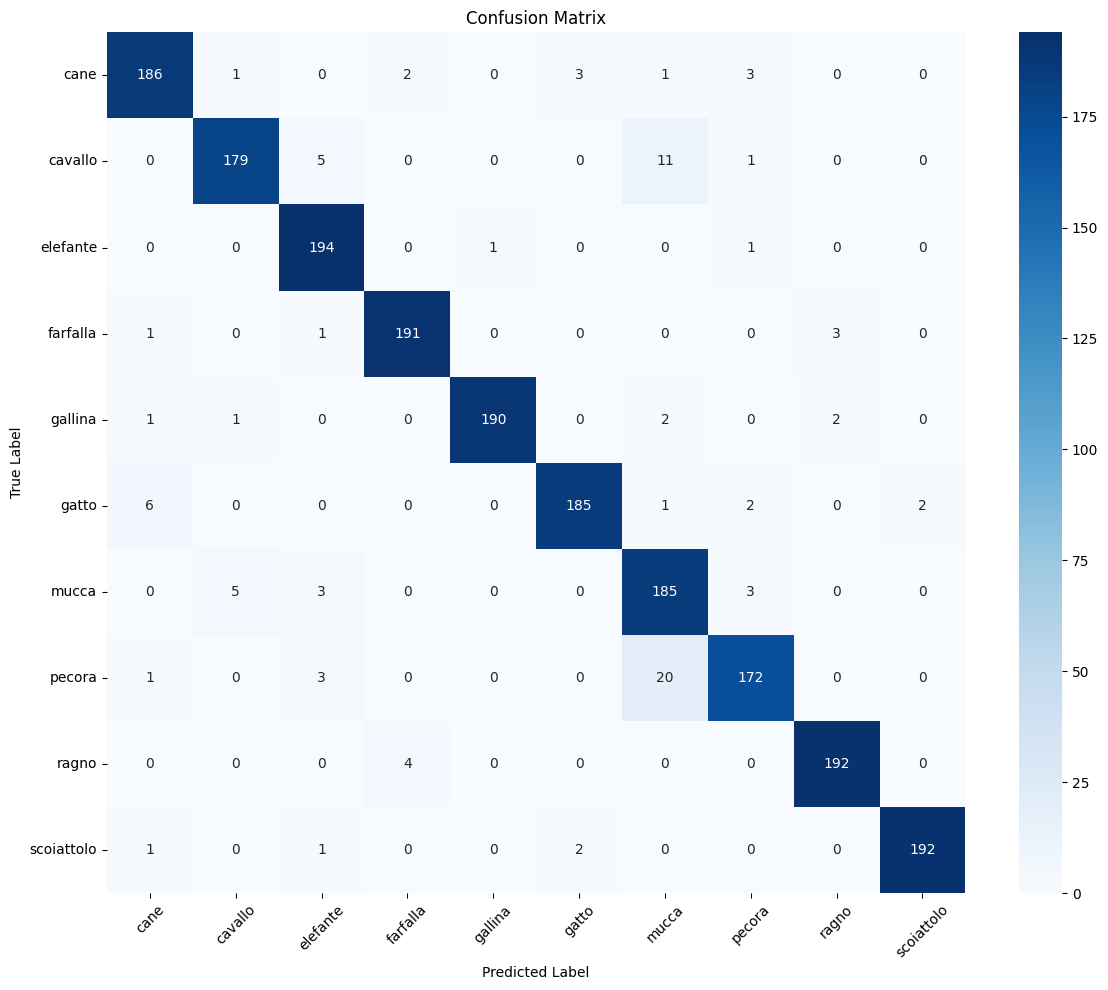


Per-class Accuracy:
cane: 94.90%
cavallo: 91.33%
elefante: 98.98%
farfalla: 97.45%
gallina: 96.94%
gatto: 94.39%
mucca: 94.39%
pecora: 87.76%
ragno: 97.96%
scoiattolo: 97.96%

Worst performing classes:
  pecora: 87.76%
  cavallo: 91.33%
  gatto: 94.39%

Best performing classes:
  elefante: 98.98%
  scoiattolo: 97.96%
  ragno: 97.96%


In [16]:
# ========== BAGIAN 14: MODEL ANALYSIS ==========
def analyze_model_performance():
    """Analyze model performance in detail"""
    
    if not all([
        'test_generator' in globals(),
        'class_names' in globals(), 
        os.path.exists(best_model_path)
    ]):
        print("❌ Required components not available for analysis")
        return
    
    model = tf.keras.models.load_model(best_model_path)
    
    # Get all test predictions
    print("Analyzing model performance on entire test set...")
    
    # Reset generator
    test_generator.reset()
    
    # Get predictions
    predictions = model.predict(test_generator, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Get true labels
    true_classes = test_generator.classes
    
    # Calculate metrics
    from sklearn.metrics import classification_report, confusion_matrix
    import seaborn as sns
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(true_classes, predicted_classes, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Per-class accuracy
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    
    print("\nPer-class Accuracy:")
    for i, (class_name, accuracy) in enumerate(zip(class_names, class_accuracies)):
        print(f"{class_name}: {accuracy*100:.2f}%")
    
    # Find worst performing classes
    worst_classes = np.argsort(class_accuracies)[:3]
    print(f"\nWorst performing classes:")
    for idx in worst_classes:
        print(f"  {class_names[idx]}: {class_accuracies[idx]*100:.2f}%")
    
    # Find best performing classes  
    best_classes = np.argsort(class_accuracies)[-3:]
    print(f"\nBest performing classes:")
    for idx in reversed(best_classes):
        print(f"  {class_names[idx]}: {class_accuracies[idx]*100:.2f}%")

# Run performance analysis
analyze_model_performance()

## Persiapan File Submission
Membuat file zip dari folder `submission`.

In [17]:
# ========== BAGIAN 15: CREATE SUBMISSION FILES ==========
def create_submission_files():
    """Create all required submission files"""
    
    # Create requirements.txt
    requirements_content = """tensorflow>=2.16.0
numpy>=1.21.0
matplotlib>=3.5.0
pillow>=8.0.0
split-folders>=0.5.1
tensorflowjs>=3.0.0
scikit-learn>=1.0.0
seaborn>=0.11.0
"""
    
    requirements_path = os.path.join(submission_dir, 'requirements.txt')
    with open(requirements_path, 'w') as f:
        f.write(requirements_content)
    print(f"✅ requirements.txt created at: {requirements_path}")
    
    # Create enhanced README.md
    actual_class_names_str = ', '.join(class_names) if 'class_names' in globals() and class_names else 'N/A'
    actual_test_accuracy_str = f"{test_accuracy*100:.2f}%" if 'test_accuracy' in globals() and test_accuracy else 'N/A (belum dievaluasi)'
    actual_num_layers_str = str(len(model.layers)) if 'model' in globals() and model and hasattr(model, 'layers') else 'N/A'
    
    readme_content = f"""# Proyek Klasifikasi Gambar: Animals-10

## Deskripsi
Proyek ini adalah submission untuk kelas Belajar Machine Learning untuk Pemula dari Dicoding. Tujuan proyek ini adalah untuk membangun model klasifikasi gambar yang mampu mengenali 10 jenis hewan berbeda dari dataset "Animals-10" yang diambil dari Kaggle.

Dataset terdiri dari sekitar 28.000 gambar hewan yang terbagi dalam 10 kategori: {actual_class_names_str}.

## Detail Implementasi
- **Nama:** Muhammad Hasan Fadhlillah
- **Email:** mc006d5y2342@student.devacademy.id
- **ID Dicoding:** MC006D5Y2342
- **Dataset**: Animals-10 dari Kaggle (oleh alessiocorrado99)
- **Path Dataset di Kaggle**: /kaggle/input/{dataset_input_name_kaggle}/raw-img
- **Ukuran Gambar Input**: {IMG_WIDTH}x{IMG_HEIGHT}
- **Batch Size**: {BATCH_SIZE}
- **Arsitektur Model**: Transfer Learning dengan EfficientNetB0 + Custom layers ({actual_num_layers_str} lapisan total)
- **Optimizer**: Adam dengan learning rate adaptif
- **Loss Function**: Categorical Crossentropy
- **Callbacks**: ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
- **Target Akurasi Dicoding**: >85% (Wajib), >95% (Saran untuk Bintang 5)
- **Akurasi Test Aktual**: {actual_test_accuracy_str}

## Teknik yang Digunakan untuk Mencapai Akurasi >95%
1. **Transfer Learning**: Menggunakan EfficientNetB0 pre-trained pada ImageNet
2. **Two-Phase Training**: 
   - Phase 1: Frozen base model (20 epochs)
   - Phase 2: Fine-tuning dengan learning rate sangat kecil (30 epochs)
3. **Advanced Data Augmentation**: Rotasi, shift, zoom, brightness, dll.
4. **Batch Normalization**: Untuk stabilitas training
5. **Dropout Layers**: Untuk mencegah overfitting
6. **Learning Rate Scheduling**: ReduceLROnPlateau callback
7. **Early Stopping**: Dengan patience untuk mencegah overfitting

## Struktur Direktori Submission
```
submission/
├── tfjs_model/
│   ├── group1-shard1of1.bin
│   └── model.json
├── tflite_model/
│   ├── model.tflite
│   └── labels.txt
├── saved_model/
│   ├── saved_model.pb
│   └── variables/
├── proyek-klasifikasi-gambar-animals10-classification.ipynb
├── README.md
└── requirements.txt
```

## Cara Menjalankan di Kaggle
1. Buat notebook baru di Kaggle
2. Tambahkan dataset "Animals-10" (oleh alessiocorrado99) ke notebook
3. Pastikan GPU/TPU aktif di pengaturan notebook
4. Copy-paste semua code dari notebook ini
5. Jalankan semua sel secara berurutan
6. Save & Run All (Commit) setelah selesai
7. Download file submission.zip dari tab Output

## Format Model yang Dihasilkan
- **SavedModel**: Format standar TensorFlow untuk deployment
- **TF-Lite**: Format optimized untuk mobile/edge devices
- **TensorFlow.js**: Format untuk deployment di web browser

## Catatan Penting
- Model menggunakan Transfer Learning untuk mencapai akurasi tinggi
- Dataset dapat dikurangi menjadi 13.000 gambar untuk mempercepat training
- Two-phase training approach untuk hasil optimal
- Model telah dioptimasi untuk berbagai platform deployment
"""
    
    readme_md_path = os.path.join(submission_dir, 'README.md')
    with open(readme_md_path, 'w') as f:
        f.write(readme_content)
    print(f"✅ README.md created at: {readme_md_path}")
    
    # Copy the notebook file to submission directory
    notebook_name = 'proyek-klasifikasi-gambar-animals10-classification.ipynb'
    notebook_source = f'/kaggle/input/{notebook_name}'  # Adjust if needed
    notebook_dest = os.path.join(submission_dir, notebook_name)
    
    # If notebook exists in input, copy it
    if os.path.exists(notebook_source):
        try:
            shutil.copy2(notebook_source, notebook_dest)
            print(f"✅ Notebook copied to: {notebook_dest}")
        except Exception as e:
            print(f"⚠️ Could not copy notebook: {e}")
    else:
        print(f"⚠️ Notebook not found at: {notebook_source}")
        print("💡 Manual action: Copy your notebook file to submission folder")
    
    print("\n" + "="*60)
    print("SUBMISSION FILES CREATION COMPLETED!")
    print("="*60)
    
    # Check all required files
    required_files = [
        'saved_model/',
        'tflite_model/model.tflite', 
        'tflite_model/labels.txt',
        'tfjs_model/',
        'README.md',
        'requirements.txt'
    ]
    
    print("\nChecking required files:")
    all_present = True
    for file_path in required_files:
        full_path = os.path.join(submission_dir, file_path)
        if os.path.exists(full_path):
            if os.path.isdir(full_path):
                file_count = len([f for f in os.listdir(full_path) if os.path.isfile(os.path.join(full_path, f))])
                print(f"✅ {file_path} (contains {file_count} files)")
            else:
                file_size = os.path.getsize(full_path) / 1024  # KB
                print(f"✅ {file_path} ({file_size:.1f} KB)")
        else:
            print(f"❌ {file_path} - MISSING!")
            all_present = False
    
    if all_present:
        print("\n🎉 All required files are present!")
    else:
        print("\n⚠️ Some required files are missing. Please check the conversion steps.")
    
    print("\n" + "="*80)
    print("🎉 PROYEK KLASIFIKASI GAMBAR SELESAI!")
    print("="*80)
    print("📋 Summary:")
    print(f"   - Model Architecture: Transfer Learning (EfficientNetB0)")
    print(f"   - Test Accuracy: {actual_test_accuracy_str}") 
    print(f"   - Model Formats: SavedModel, TF-Lite, TensorFlow.js")
    print(f"   - Submission File: {submission_zip_filename}")
    print("="*80)

    return submission_dir

# Variables for submission
submission_zip_filename = 'submission.zip'
submission_zip_path = os.path.join(working_dir, submission_zip_filename)

# Run the function
create_submission_files()

# Create final ZIP file
def create_final_zip():
    """Create the final submission ZIP file"""
    try:
        if os.path.exists(submission_dir) and os.listdir(submission_dir):
            print(f"\nCreating final submission ZIP: {submission_zip_path}")
            # Using zipfile for better control
            with zipfile.ZipFile(submission_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
                for root, dirs, files in os.walk(submission_dir):
                    for file in files:
                        file_path = os.path.join(root, file)
                        # Create proper archive name (relative path inside zip)
                        arcname = os.path.relpath(file_path, start=os.path.dirname(submission_dir))
                        zipf.write(file_path, arcname=arcname)
                        
            zip_size = os.path.getsize(submission_zip_path) / (1024 * 1024)  # MB
            print(f"✅ Submission ZIP created: {submission_zip_path}")
            print(f"📊 ZIP file size: {zip_size:.2f} MB")
            print(f"📁 Download '{submission_zip_filename}' from Kaggle Output tab after commit")
            
            # List ZIP contents for verification
            print(f"\nZIP Contents:")
            with zipfile.ZipFile(submission_zip_path, 'r') as zipf:
                for info in zipf.infolist():
                    size_kb = info.file_size / 1024
                    print(f"  {info.filename} ({size_kb:.1f} KB)")
                    
        else:
            print(f"❌ Submission folder {submission_dir} not found or empty")
            
    except Exception as e:
        print(f"❌ Error creating ZIP file: {e}")
        print("💡 You can manually zip the submission folder contents")

create_final_zip()

✅ requirements.txt created at: /kaggle/working/submission/requirements.txt
✅ README.md created at: /kaggle/working/submission/README.md
⚠️ Notebook not found at: /kaggle/input/proyek-klasifikasi-gambar-animals10-classification.ipynb
💡 Manual action: Copy your notebook file to submission folder

SUBMISSION FILES CREATION COMPLETED!

Checking required files:
✅ saved_model/ (contains 2 files)
✅ tflite_model/model.tflite (5580.2 KB)
✅ tflite_model/labels.txt (0.1 KB)
✅ tfjs_model/ (contains 6 files)
✅ README.md (2.9 KB)
✅ requirements.txt (0.1 KB)

🎉 All required files are present!

🎉 PROYEK KLASIFIKASI GAMBAR SELESAI!
📋 Summary:
   - Model Architecture: Transfer Learning (EfficientNetB0)
   - Test Accuracy: 95.18%
   - Model Formats: SavedModel, TF-Lite, TensorFlow.js
   - Submission File: submission.zip

Creating final submission ZIP: /kaggle/working/submission.zip
✅ Submission ZIP created: /kaggle/working/submission.zip
📊 ZIP file size: 56.03 MB
📁 Download 'submission.zip' from Kaggle O